# GPT2-Sentiment Classification

In [28]:
import json
import os
import re
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

## Helper Function

In [29]:
# Helper function to process our corpus
def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip().lower()

## Helper Class

In [39]:
class Gpt2ClassificationCollator(object):
    """
    Data Collator used for GPT2 in a classificaiton rask.
    """
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        # tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        """
        Load Text and Inputs
        """
        # get all text and label.
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        # encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # use tokenizer get input
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,
                                    max_length=self.max_sequence_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    """
    Train pytorch model on a single pass through the data loader.
    """
    global model
    predictions_label = []
    true_label = []
    
    total_loss = 0

    # Set as train mode.
    model.train()
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_label += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)

        # get logits and loss 
        loss, logits = outputs[:2]
        
        # update Loss 
        total_loss += loss.item()
        
        # Backward propagation for gradients
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # optimize 
        optimizer_.step()
        # update the learning rate.
        scheduler_.step()
        # get logits and final label
        logits = logits.detach().cpu().numpy()
        predictions_label += logits.argmax(axis=-1).flatten().tolist()
            
                
    # get avg loss
    avg_epoch_loss = total_loss / len(dataloader)

    return true_label, predictions_label, avg_epoch_loss



class TextDataset(Dataset):
    def __init__(self, df, use_tokenizer=None):
        """
        df: pandas DataFrame with 'text' and 'label' columns.
        """
        self.texts = df['category_description'].tolist()
        self.labels = df['rating'].tolist()
        self.n_examples = len(self.labels)
        self.use_tokenizer = use_tokenizer

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
       
        text = self.texts[item]
        label = self.labels[item]
        
        if self.use_tokenizer:
            text = self.use_tokenizer(text)

        return {'text': text, 'label': label}

def validation(dataloader, device_):

    global model
    # save labels
    predictions_labels = []
    true_labels = []
    # total loss for this epoch.
    total_loss = 0

    # evalute
    model.eval()
    for batch in tqdm(dataloader, total=len(dataloader)):
         
        # add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()
        # move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
         
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            # update loss
            total_loss += loss.item()

            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

    # get avg loss
    avg_epoch_loss = total_loss / len(dataloader)

    return true_labels, predictions_labels, avg_epoch_loss

## Training Setting

In [40]:
set_seed(0)
# for model
epochs = 3
batch_size = 32
max_length = 128
# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# the model we want to use.
model_name_or_path = 'gpt2'

In [66]:
## Load data
data = []
file = 'All_Beauty.jsonl'
with open(file, 'r') as fp:
    for line in fp:
        if line.strip():  # avoid empty lines
            record = json.loads(line)
            data.append({'rating': record.get('rating'), 'text': record.get('text')})

df = pd.DataFrame(data)

df['text'] = df['text'].map(preprocess)
df = df[df['rating'] != 3]
df['rating'] = df['rating'].replace({5: 'Positive', 4: 'Positive', 2: 'Negative', 1: 'Negative'})
n_labels = 2

In [67]:
# train/test-spilte
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# labels 
labels_ids = { 'Positive': 1, 'Negative': 0}

print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# get model tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# padding setting
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

Loading configuraiton...
Loading tokenizer...


In [43]:

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding as len of tokenize
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id 
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [44]:
print('Dealing with Train...')
# create train set
train_dataset = TextDataset(train_df)
print('Created `train_dataset` with %d examples!'%len(train_dataset))
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with Validation...')
# create test set
valid_dataset =  TextDataset(test_df)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))
# Out optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8.
                  )

total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}

all_acc = {'train_acc':[], 'val_acc':[]}


print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))

    # get loss value for plotting the learning curve
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

Dealing with Train...
Created `train_dataset` with 516176 examples!
Created `train_dataloader` with 16131 batches!
Dealing with Validation...
Created `valid_dataset` with 129045 examples!
Created `eval_dataloader` with 4033 batches!
Epoch


G:\Anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/16131 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/4033 [00:00<?, ?it/s]

  train_loss: 0.13470 - val_loss: 0.10502 - train_acc: 0.94920 - valid_acc: 0.96242

Training on batches...


  0%|          | 0/16131 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/4033 [00:00<?, ?it/s]

  train_loss: 0.09361 - val_loss: 0.09802 - train_acc: 0.96691 - valid_acc: 0.96568

Training on batches...


  0%|          | 0/16131 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/4033 [00:00<?, ?it/s]

  train_loss: 0.07306 - val_loss: 0.10838 - train_acc: 0.97584 - valid_acc: 0.96629


In [48]:
data = {**all_loss, **all_acc}
df = pd.DataFrame(data)
df.to_csv('All_epoch_loss_acc.csv')

In [49]:
model.save_pretrained("GPT2_label")
tokenizer.save_pretrained("GPT2_label")

('GPT2_label\\tokenizer_config.json',
 'GPT2_label\\special_tokens_map.json',
 'GPT2_label\\vocab.json',
 'GPT2_label\\merges.txt',
 'GPT2_label\\added_tokens.json')

# Plot Loss

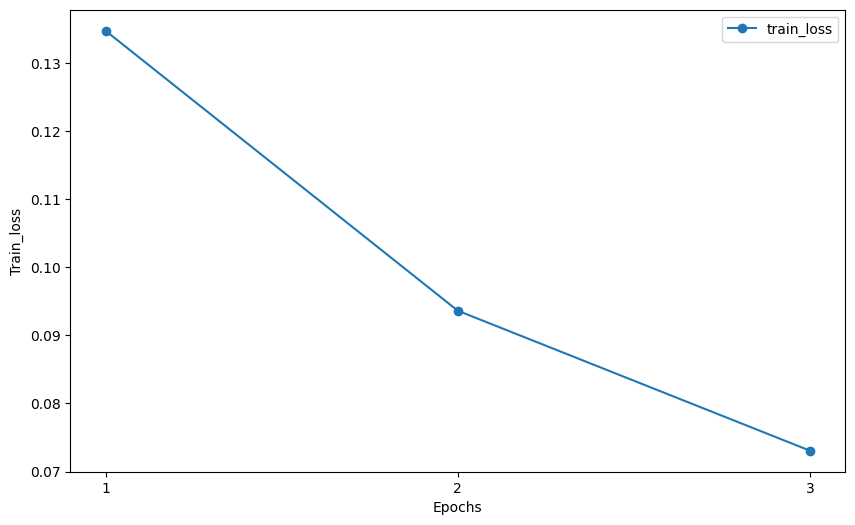

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index+1, df['train_loss'], label='train_loss', marker='o')
plt.xticks(ticks=(df.index + 1))
plt.xlabel('Epochs')
plt.ylabel('Train_loss')
plt.legend()
plt.show()

# classification report

In [60]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

inputs = tokenizer(
    test_df['text'].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_length
)
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
batch_size = 16  
dataloader = DataLoader(dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)

        batch_inputs = {
            'input_ids': batch_input_ids,
            'attention_mask': batch_attention_mask
        }

        outputs = model(**batch_inputs)
        logits = outputs.logits

        # get prediction
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()

        # append prediction
        all_predictions.extend(predictions)

all_predictions = torch.tensor(all_predictions).numpy()

In [68]:
labels_ids = {'Positive': 1, 'Negative': 0}
test_df['rating']
id_to_labels = {v: k for k, v in labels_ids.items()}
predicted_labels = [id_to_labels[pred] for pred in all_predictions]


report = classification_report(
    test_df['rating'],
    predicted_labels,
    target_names=labels_ids.keys()
)
print(report)

              precision    recall  f1-score   support

    Positive       0.92      0.92      0.92     28842
    Negative       0.98      0.98      0.98    100203

    accuracy                           0.96    129045
   macro avg       0.95      0.95      0.95    129045
weighted avg       0.96      0.96      0.96    129045

